<a href="https://colab.research.google.com/github/BayramAlpSahin/EE491-492Project/blob/main/Denoising_Autoencoder_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [2]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

In [8]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=1),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=1),
      layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=1),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2),
      ])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(32, kernel_size=3, strides=1, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=1, activation='relu', padding='same'),
      layers.Conv2DTranspose(8, kernel_size=3, strides=1, activation='relu', padding='same'),
      layers.Conv2DTranspose(1, kernel_size=3, strides=1, activation='relu', padding='same'),])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

model = Denoise()

In [9]:
model.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [ ]:
#Train the model by making it predict the original image from the noisy version
model.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

In [11]:
model.encoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 8)         80        
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 16)        1168      
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 32)        4640      
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 8)         2312      
                                                                 
 conv2d_8 (Conv2D)           (None, 7, 7, 8)           584       
                                                                 
Total params: 8784 (34.31 KB)
Trainable params: 8784 (34.31 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
model.decoder.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose_2 (Conv2D  (None, 14, 14, 8)         584       
 Transpose)                                                      
                                                                 
 conv2d_transpose_3 (Conv2D  (None, 28, 28, 8)         584       
 Transpose)                                                      
                                                                 
 conv2d_transpose_4 (Conv2D  (None, 28, 28, 32)        2336      
 Transpose)                                                      
                                                                 
 conv2d_transpose_5 (Conv2D  (None, 28, 28, 16)        4624      
 Transpose)                                                      
                                                                 
 conv2d_transpose_6 (Conv2D  (None, 28, 28, 8)        

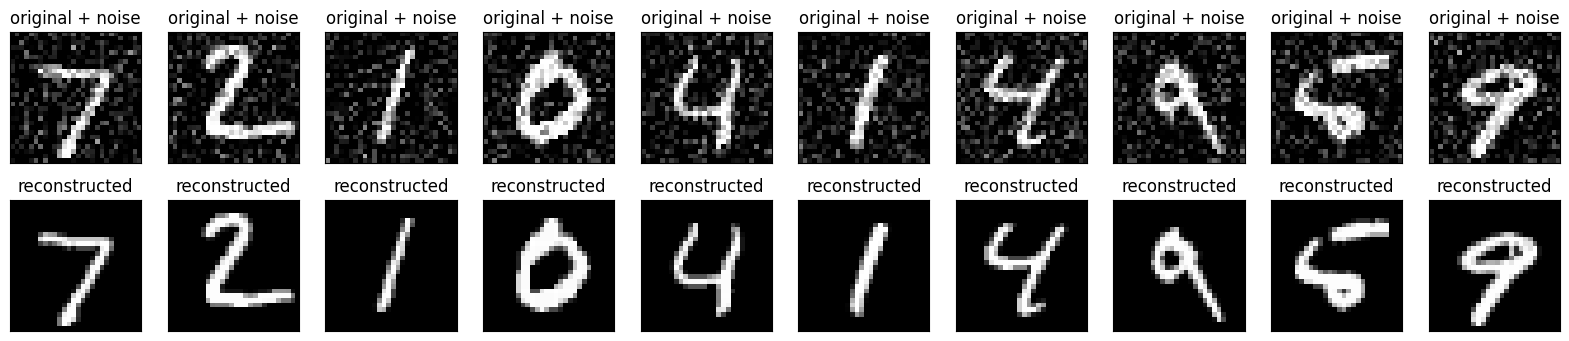

In [13]:
#First 10 images in the test dataset visualised
encoded_imgs = model.encoder(x_test_noisy).numpy()
decoded_imgs = model.decoder(encoded_imgs).numpy()

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(x_test[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()